# Cold Start Data Project

The objective of this project is to forecast energy consumption from varying amounts of "cold start" data, and little other building information. That means that for each building in the test set you are given a small amount of data and then asked to predict into the future. 

In [232]:
import os
import numpy as np
import datetime
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from pandas import Series
from matplotlib import pyplot
from collections import Counter
from datetime import date
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5] 
#from fbprophet import Prophet
from scipy.stats import mode
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression, Ridge, Lasso,  RidgeCV 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [233]:
test = pd.read_csv("Data/test-data.csv", parse_dates=['timestamp'], delimiter=';') #hourly time step
train = pd.read_csv("Data/training-data.csv",  parse_dates=['timestamp'],delimiter=';')
metadata = pd.read_csv("Data/metadata.csv",  delimiter=';')

### Merging data with metada

In [234]:
train_meta = pd.merge(train,
                 metadata,
                 on='series_id', how = 'left')

train_meta['timestamp'] = pd.to_datetime(train_meta['timestamp'], utc=True)
train_meta.set_index('timestamp', inplace=True)
train_meta.head()

,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
timestamp,,,,,,,,,,,,
2015-04-04 21:00:00+00:00,102838,26003.071660,NaN,xx-large,low,False,False,False,False,False,True,True
2015-04-05 01:00:00+00:00,102838,27689.354069,NaN,xx-large,low,False,False,False,False,False,True,True
2015-04-05 02:00:00+00:00,102838,26092.608779,NaN,xx-large,low,False,False,False,False,False,True,True
2015-04-05 13:00:00+00:00,102838,24503.324916,13.416667,xx-large,low,False,False,False,False,False,True,True
2015-04-05 15:00:00+00:00,102838,26592.524360,13.000000,xx-large,low,False,False,False,False,False,True,True


In [235]:
test_meta = pd.merge(test,
                 metadata,
                 on='series_id', how = 'left')
test_meta['timestamp'] = pd.to_datetime(test_meta['timestamp'], utc=True)
test_meta.set_index('timestamp', inplace=True)
test_meta.head()

,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
timestamp,,,,,,,,,,,,
2016-03-06 13:00:00+00:00,101047,4794.353543,10.977273,x-small,low,False,False,False,False,False,True,True
2017-01-25 17:00:00+00:00,100203,9011.298540,7.909091,x-small,low,False,False,False,False,False,True,True
2017-01-25 20:00:00+00:00,100203,6608.533944,2.900000,x-small,low,False,False,False,False,False,True,True
2017-01-27 12:00:00+00:00,100203,8892.091614,6.272727,x-small,low,False,False,False,False,False,True,True
2017-01-27 18:00:00+00:00,100203,9756.341826,4.272727,x-small,low,False,False,False,False,False,True,True


In [236]:
buildings_train = train_meta.series_id
print('Training data set unique buildings:', len(set(buildings_train)))
buildings_test = test_meta.series_id
print('Testing data set unique buildings:', len(set(buildings_test)))


Training data set unique buildings: 758
Testing data set unique buildings: 625


### Handling NAs

In [237]:
train_meta.isna().sum()

series_id                    0
consumption                  0
temperature             228689
surface                      0
base_temperature             0
monday_is_day_off            0
tuesday_is_day_off           0
wednesday_is_day_off         0
thursday_is_day_off          0
friday_is_day_off            0
saturday_is_day_off          0
sunday_is_day_off            0
dtype: int64

In [238]:
train_meta.dropna(subset=['temperature'],how='any',inplace=True) 

In [239]:
test_meta.isna().sum()

series_id                   0
consumption                 0
temperature             44916
surface                     0
base_temperature            0
monday_is_day_off           0
tuesday_is_day_off          0
wednesday_is_day_off        0
thursday_is_day_off         0
friday_is_day_off           0
saturday_is_day_off         0
sunday_is_day_off           0
dtype: int64

In [240]:
test_meta.dropna(subset=['temperature'],how='any',inplace=True) 

## Plots

Text(0.5, 1.0, 'Temperature vs Consumption')

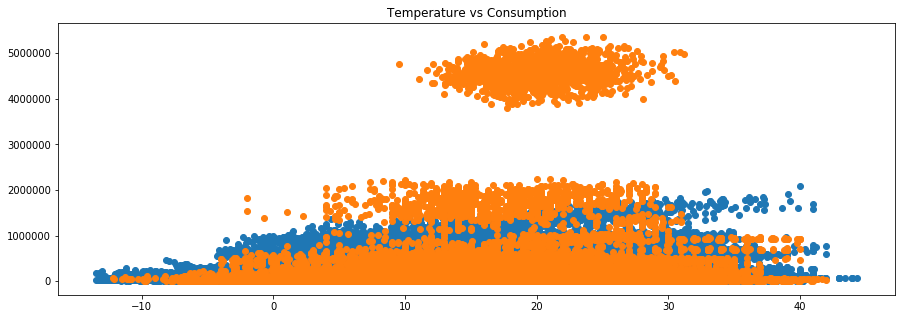

In [241]:
plt.scatter( train_meta.temperature, train_meta.consumption)
plt.scatter( test_meta.temperature, test_meta.consumption) #orange 
plt.title('Temperature vs Consumption')

### Plot rates of consumption


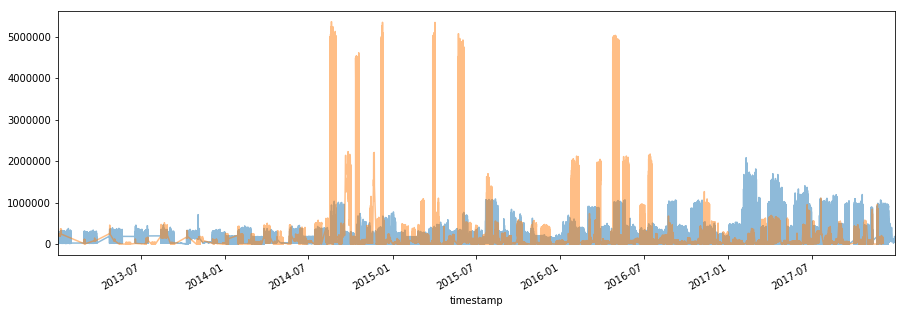

In [242]:
consumption_train = train_meta.consumption
# raw data plot
consumption_train.plot(alpha=0.5, style='-', label='Training')

consumption_test = test_meta.consumption
consumption_test.plot(alpha=0.5, style='-', label = 'Test')

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


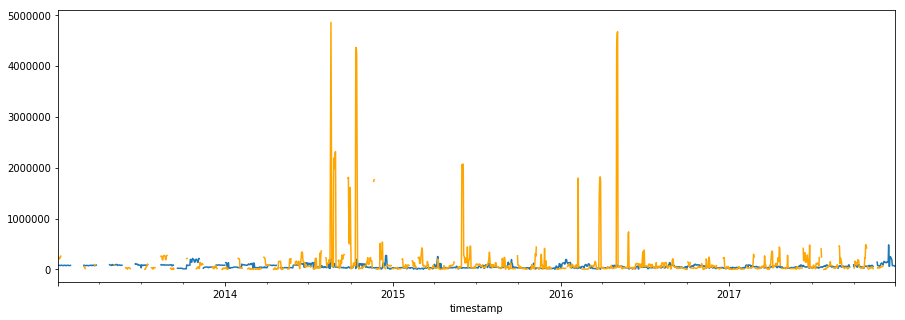

In [243]:
# resample by taking the daily consumption mean
consumption_train.resample('D').median().plot(style='-')
consumption_test.resample('D').median().plot(style='-',color='orange')
#plot consumption by temperature. 1D LR with consumption (y) temperature (x)
#potentially really large buildings in test

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


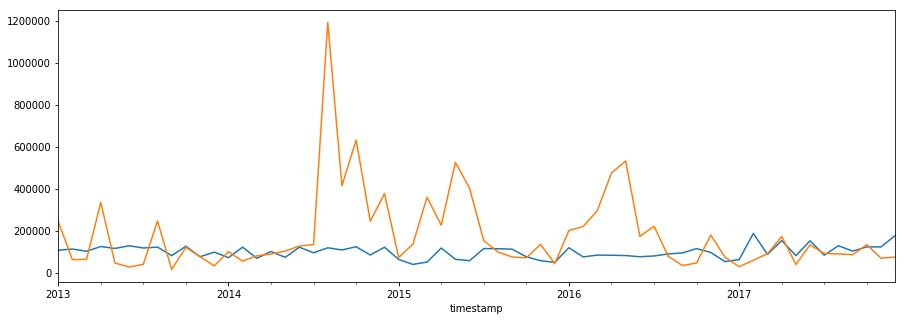

In [244]:
# resample by taking the monthly consumption mean
consumption_train.resample('M').mean().plot(style='-');
consumption_test.resample('M').mean().plot(style='-');

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


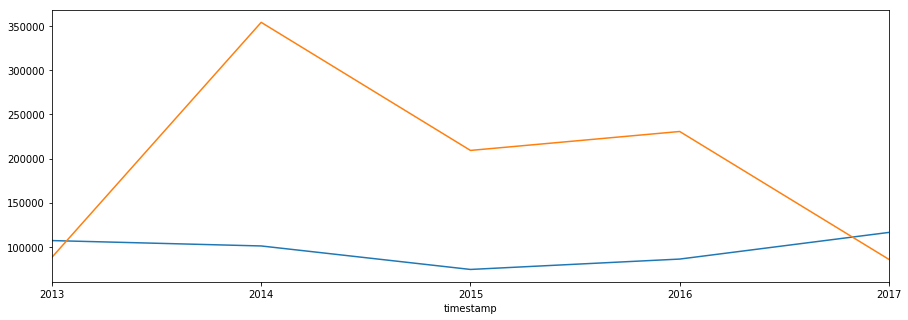

In [245]:
# and a pretty uncorrelated decrease and then increase in mean consumption (yearly)
consumption_train.resample('A').mean().plot(style='-');
consumption_test.resample('A').mean().plot(style='-');

### Temperature Plots

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


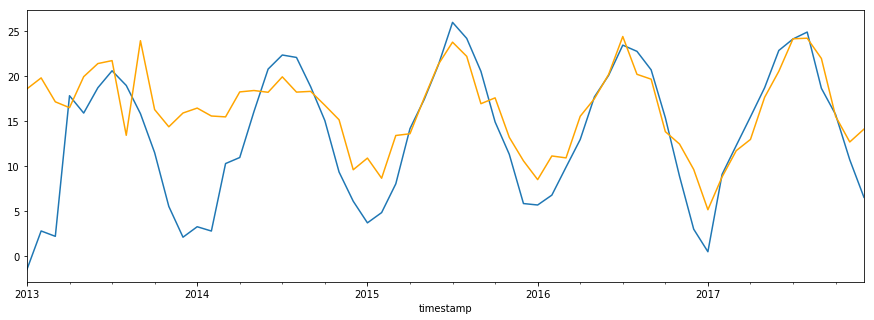

In [248]:
# notice the seasonality in the temperatures here. we don't really see this in the consumption data at the aggregate mean level. 
train_meta.temperature.resample('M').mean().plot(style='-')
test_meta.temperature.resample('M').mean().plot(style='-', color='orange')

C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\596050\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


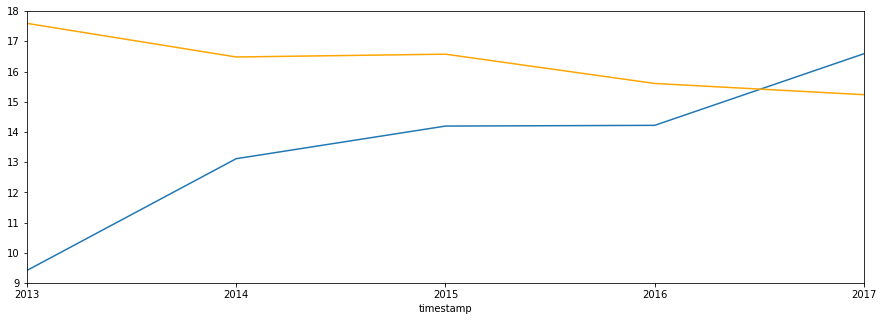

In [249]:
# we do see an overall increase in yearly temp 
train_meta.temperature.resample('A').mean().plot(style='-');
test_meta.temperature.resample('A').mean().plot(style='-', color='orange')


Test and train data are potentially from different locations

### Plots by surface area category
now we will make new columns (one for each line we want to plot like x-small, large, etc)
then it will plot each column as a different line. 

In [250]:
# get the daily total for each type, and put into a daily consumption table. 

def daily_sum(df,surface_type):
    ''' df = dataframe, measure = the column you want to include i.e. consumption, surface_type=variable in the surface column you are selecting'''
    
    newdf = df[df.surface==surface_type].resample('D').sum()
    newdf_c=pd.DataFrame()
    newdf_c[surface_type] = newdf.consumption
    return newdf_c

In [251]:
xxsmall_con = daily_sum(train_meta,'xx-small')
xsmall_con = daily_sum(train_meta,'x-small')
small_con = daily_sum(train_meta, 'small')
medium_con = daily_sum(train_meta,'medium')
large_con = daily_sum(train_meta,'large')
xlarge_con = daily_sum(train_meta,'x-large')
xxlarge_con = daily_sum(train_meta,'xx-large')

In [252]:
surface_consumption = pd.merge(xxsmall_con,xsmall_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,small_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,medium_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,large_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,xlarge_con, right_index=True,left_index=True)
surface_consumption = pd.merge(surface_consumption,xxlarge_con, right_index=True,left_index=True)

surface_consumption.head()

,xx-small,x-small,small,medium,large,x-large,xx-large
timestamp,,,,,,,
2016-01-24 00:00:00+00:00,0.000000,0.000000,7.118566e+05,1.667639e+06,7.558571e+06,2.229414e+05,0.0
2016-01-25 00:00:00+00:00,0.000000,310258.829235,5.263797e+06,2.801335e+06,9.412651e+06,3.819413e+06,0.0
2016-01-26 00:00:00+00:00,913820.782653,301663.800209,7.133986e+06,2.758980e+06,8.718243e+06,3.987499e+06,0.0
2016-01-27 00:00:00+00:00,850558.149467,311529.683726,6.797021e+06,2.689985e+06,8.582801e+06,8.962491e+06,0.0
2016-01-28 00:00:00+00:00,916145.715014,315799.650701,7.480217e+06,8.977507e+05,8.708509e+06,9.067872e+06,0.0


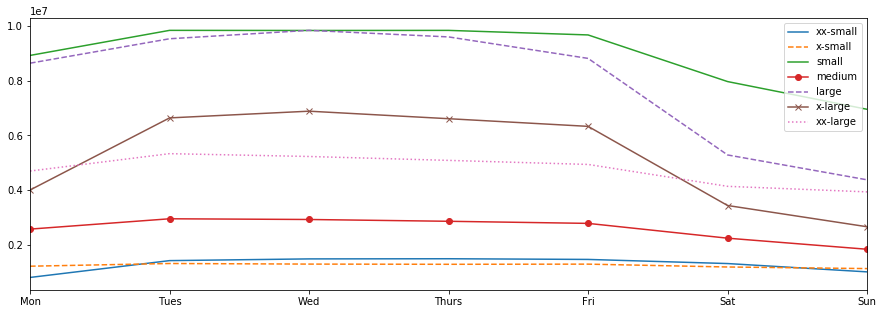

In [253]:
by_weekday = surface_consumption.groupby(surface_consumption.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', '-','o-','--','x-',':']);

Consumption can be seen to go down on the weekends. 

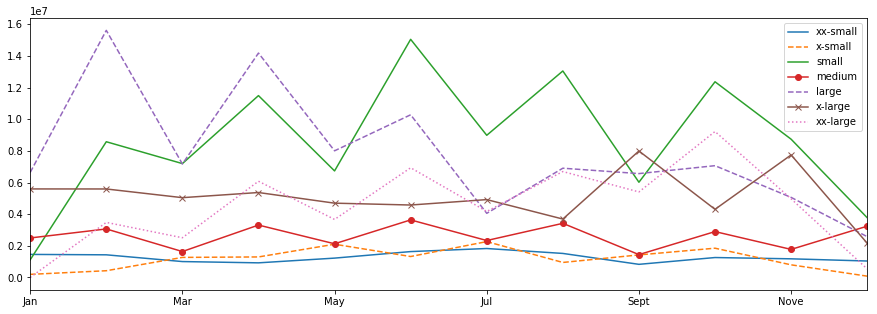

In [254]:
by_month = surface_consumption.groupby(surface_consumption.index.month).mean()
by_month.index = ['Jan', 'Feb', 'Mar', 'Ap','May', 'Jun', 'Jul', 'Aug','Sept','Oct','Nove','Dec']
by_month.plot(style=['-', '--', '-','o-','--','x-',':']);

### Features

In [255]:
train_meta.loc[:,'dayofweek'] = train_meta.index.weekday

def weekday_fcn(x):
    if x <= 4:
        return 1
    else:
        return 0
        
train_meta.loc[:,'isweekday'] = train_meta.loc[:,'dayofweek'].apply(lambda x: weekday_fcn(x))

train_meta.head()


,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,dayofweek,isweekday
timestamp,,,,,,,,,,,,,,
2015-04-05 13:00:00+00:00,102838,24503.324916,13.416667,xx-large,low,False,False,False,False,False,True,True,6,0
2015-04-05 15:00:00+00:00,102838,26592.524360,13.000000,xx-large,low,False,False,False,False,False,True,True,6,0
2015-05-06 08:00:00+00:00,103245,76196.088319,18.300000,xx-large,low,False,False,False,False,False,True,True,2,1
2015-05-14 09:00:00+00:00,103245,90447.413103,19.833333,xx-large,low,False,False,False,False,False,True,True,3,1
2015-05-15 11:00:00+00:00,103245,91693.471343,18.416667,xx-large,low,False,False,False,False,False,True,True,4,1


In [256]:
test_meta.loc[:,'dayofweek'] = test_meta.index.weekday
        
test_meta.loc[:,'isweekday'] = test_meta.loc[:,'dayofweek'].apply(lambda x: weekday_fcn(x))

test_meta.head()

,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,dayofweek,isweekday
timestamp,,,,,,,,,,,,,,
2016-03-06 13:00:00+00:00,101047,4794.353543,10.977273,x-small,low,False,False,False,False,False,True,True,6,0
2017-01-25 17:00:00+00:00,100203,9011.298540,7.909091,x-small,low,False,False,False,False,False,True,True,2,1
2017-01-25 20:00:00+00:00,100203,6608.533944,2.900000,x-small,low,False,False,False,False,False,True,True,2,1
2017-01-27 12:00:00+00:00,100203,8892.091614,6.272727,x-small,low,False,False,False,False,False,True,True,4,1
2017-01-27 18:00:00+00:00,100203,9756.341826,4.272727,x-small,low,False,False,False,False,False,True,True,4,1


In [257]:
train_meta['surface_num'] = train_meta.surface.map({'xx-small':0, 'x-small':1, 'small':2, 'medium':3, 'large':4, 'x-large':5, 'xx-large':6})
test_meta['surface_num'] = test_meta.surface.map({'xx-small':0, 'x-small':1, 'small':2, 'medium':3, 'large':4, 'x-large':5, 'xx-large':6})

train_meta['base_num'] = train_meta.base_temperature.map({'low':0, 'high':1})
test_meta['base_num'] = test_meta.base_temperature.map({'low':0, 'high':1})

In [258]:
train_meta.drop(['monday_is_day_off', 'tuesday_is_day_off', 'wednesday_is_day_off', "thursday_is_day_off", 'friday_is_day_off', 'saturday_is_day_off', 'sunday_is_day_off', 'surface', 'base_temperature', 'dayofweek'], axis=1, inplace=True)
test_meta.drop(['monday_is_day_off', 'tuesday_is_day_off', 'wednesday_is_day_off', "thursday_is_day_off", 'friday_is_day_off', 'saturday_is_day_off', 'sunday_is_day_off', 'surface', 'base_temperature','dayofweek'], axis=1, inplace=True)


### linear regression

In [259]:
train_corr = train_meta[['consumption', 'surface_num', 'temperature', 'isweekday', 'base_num']]

In [260]:
test_corr = test_meta[['consumption', 'surface_num', 'temperature', 'isweekday', 'base_num']]

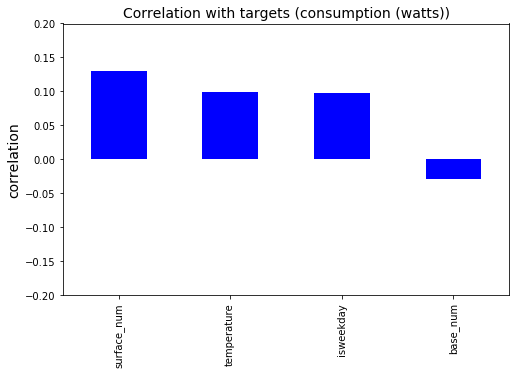

In [261]:
corrOBS = train_corr.corr()['consumption'].sort_values(ascending=False)
plt.figure(figsize=(8,5));
axes = plt.gca()
axes.set_ylim([-.2,.2])
plt.ylabel('correlation',fontsize=14)
plt.title('Correlation with targets (consumption (watts))',fontsize=14)
corrOBS[1:].plot(kind='bar', use_index=True, color='b');


### One feature regression

In [271]:
def one_feature_lr(features, xs, y):
    """ # fit each feature from the training set to the linear model 
    one at a time and plot regress and dist of residuals
    --------------------
    IN: features = number of features
        xs = array of features
        y = target values
        
    OUT: 2 plots per feature    
    """
   
    for feat in range(features):
        
        lr= LinearRegression()
        
        #if only one feature, it needs to be reshaped
        x = xs[:,feat].reshape(-1,1)
        
        #fit linear model
        lr.fit(x,y)
        
        #calculate errors
        MSE = mean_squared_error(y,lr.predict(x))
        
        #calc residuals
        resid = y - lr.predict(x)
        
        # test if residuals are normally distributed (statistically signifigant)
        p=normaltest(resid)
        
        #plot regression line vs actual targets and mean squared error
        fig2 = plt.figure()
        plt.plot(x, y,'ro', label = 'actual')
        plt.plot(x,lr.predict(x),'k', label='predicted')
        
        plt.title('Training linear regression with one feature',fontsize=14)
        plt.xlabel("Feature " + str(feat),fontsize=16)
        plt.ylabel('Consumption',fontsize=14)
        plt.grid();
        plt.legend();
        fig2.text(0.66, .70, 'MSErr = {:2f}'.format(MSE), fontsize=12);
       
       
        #plot distribution of redisuals & p-value
        fig1 = plt.figure()
        plt.hist(resid, color='b');
        plt.title('Distribution of residuals \n linear regression with 1 Feature',fontsize=14);
        plt.ylabel('number of observations',fontsize=14);
        plt.grid();
        fig1.text(0.68, .8, 'p = {:2f}'.format(p[1]), fontsize=12);
        plt.tight_layout()
        


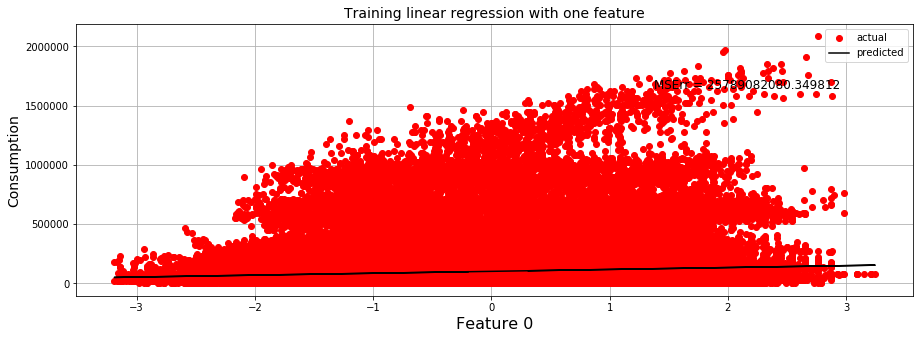

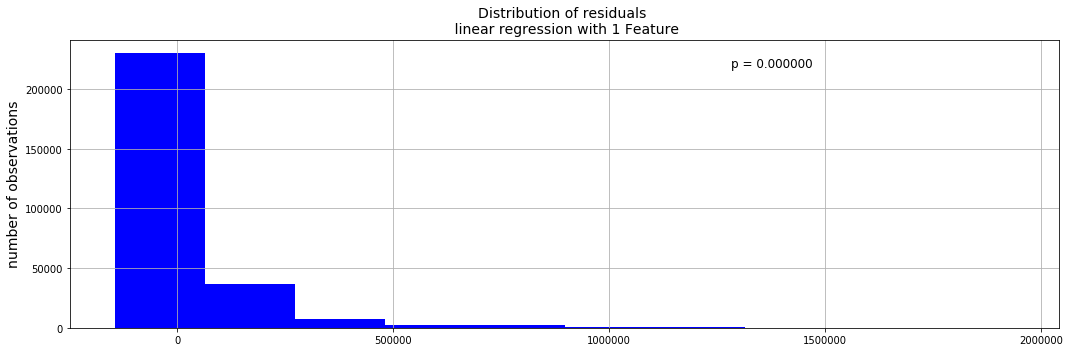

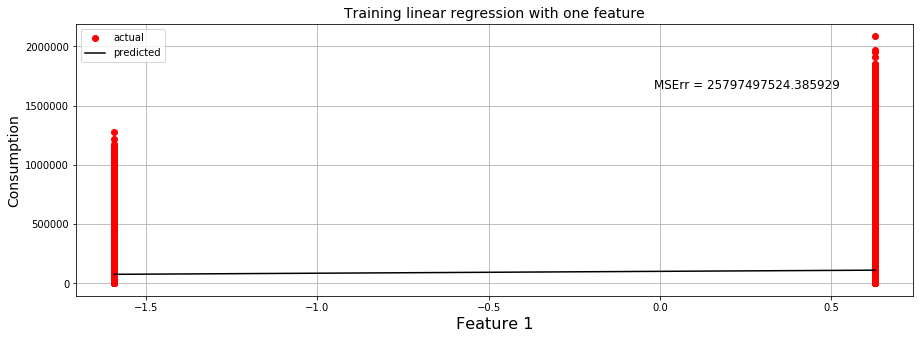

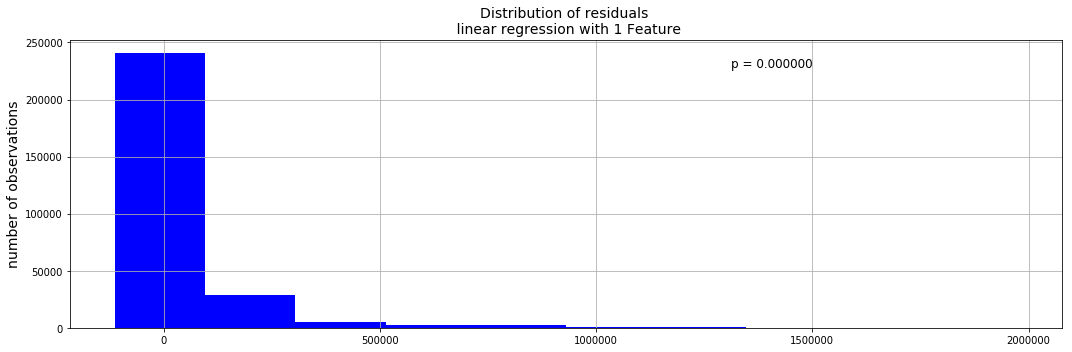

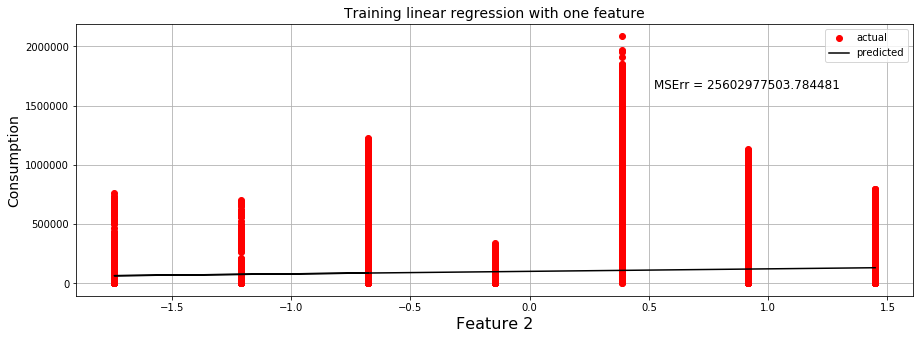

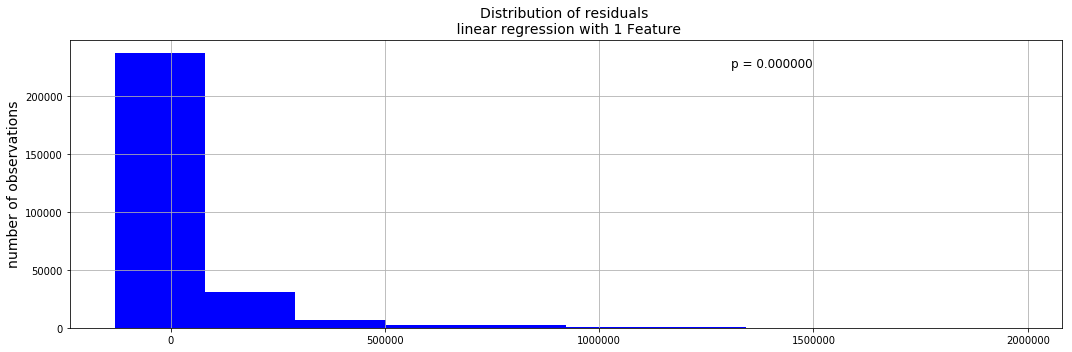

In [272]:
# call function that runs linear model for each feature against targets (training set only)
one_feature_lr(3,X_train,y)

In [264]:
X = np.array(train_meta.loc[:,['temperature', 'isweekday', 'surface_num']])
y = np.array(train_meta.loc[:,'consumption']) 

# STANDARD SCALE
stdScale = StandardScaler()
#X_train = X_train1.reshape(-1,1)
X_train = stdScale.fit_transform(X)
lr = LinearRegression()
lr.fit(X_train, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

5-fold cross validation. Cross validation is running the regression on 5 different subsets of the training data to validate that what we are getting for the prediction is correct. 

In [265]:
scores = cross_val_score(lr, X_train, y, cv=5, scoring=make_scorer(mean_squared_error))
print(scores, np.mean(scores))
y_pr = cross_val_predict(lr, X_train, y, cv=5)

[2.79554970e+10 2.24335040e+10 1.86561112e+10 2.37485340e+10
 3.25098732e+10] 25060703869.854687


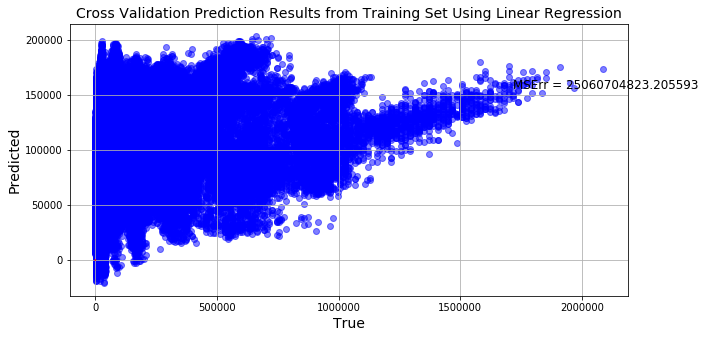

In [266]:
mse = mean_squared_error(y, y_pr)
fig4 = plt.figure(figsize=(10,5))
plt.scatter(y,y_pr,alpha = .5, color='b')
plt.plot([0,.6],[0,.6],'r-')
plt.title('Cross Validation Prediction Results from Training Set Using Linear Regression',fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('Predicted',fontsize=14)
plt.grid();
fig4.text(0.74, .7, 'MSErr = {:2f}'.format(mse), fontsize=12);

### Lasso Regression Model using grid search 5-fold cross validation

In [267]:
#set up parameters for the model and cross-validation
model = Lasso(max_iter=5000)
parameters = {'alpha': [1e-5,1e-3,1e-1,1], 'fit_intercept': [True,False]}
grid = GridSearchCV(model,parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1);
#fit to model
grid.fit(X_train, y)
# calculate error
MSE_L = mean_squared_error(y, grid.predict(X_train))

The Lasso method takes features and reduces the effect of the ones that don't contribute as much. 

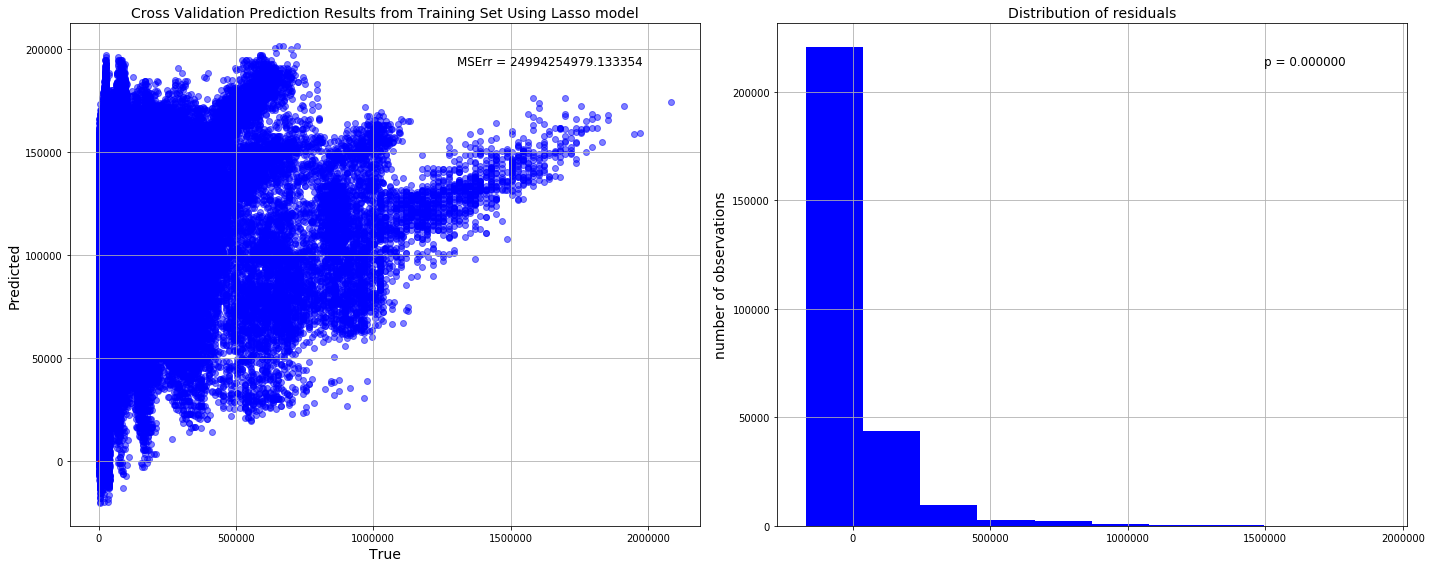

In [268]:
# plot results from the training set 
fig5 = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(y,grid.predict(X_train), alpha=.5, color='b');
plt.plot([0,.6],[0,.6],'r-')
plt.title('Cross Validation Prediction Results from Training Set Using Lasso model',fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('Predicted',fontsize=14)
plt.grid();
fig5.text(0.32, .88, 'MSErr = {:1f}'.format(MSE_L), fontsize=12);

# plot dist of residuals
plt.subplot(1,2,2)
presiddr = y-grid.predict(X_train)
pdr=normaltest(presiddr)
plt.hist(presiddr, color='b');
plt.title('Distribution of residuals',fontsize=14);
plt.ylabel('number of observations',fontsize=14);
fig5.text(0.88, .88, 'p = {:1f}'.format(pdr[1]), fontsize=12);
plt.grid()
plt.tight_layout()

#lasso selects the best feature 

We want our residuals to be randomly, normally distributed. Not the case here. 

In [269]:
X_test1 = np.array(test_meta.loc[:,['temperature', 'isweekday', 'surface_num']])
y_test = np.array(test_meta.loc[:,'consumption'])   

X_test = stdScale.fit_transform(X_test1)


grid.cv_results_
best_lasso = grid.best_estimator_
# fit the test set
lasso_pred = best_lasso.predict(X_test)
# calc residuals
residuals = []
for true,pred in zip(y_test, lasso_pred):
    residuals.append(true - pred)
# calc errors
MSE_Lt = mean_squared_error(y_test, grid.predict(X_test))
# pvalue
pdr=normaltest(residuals)

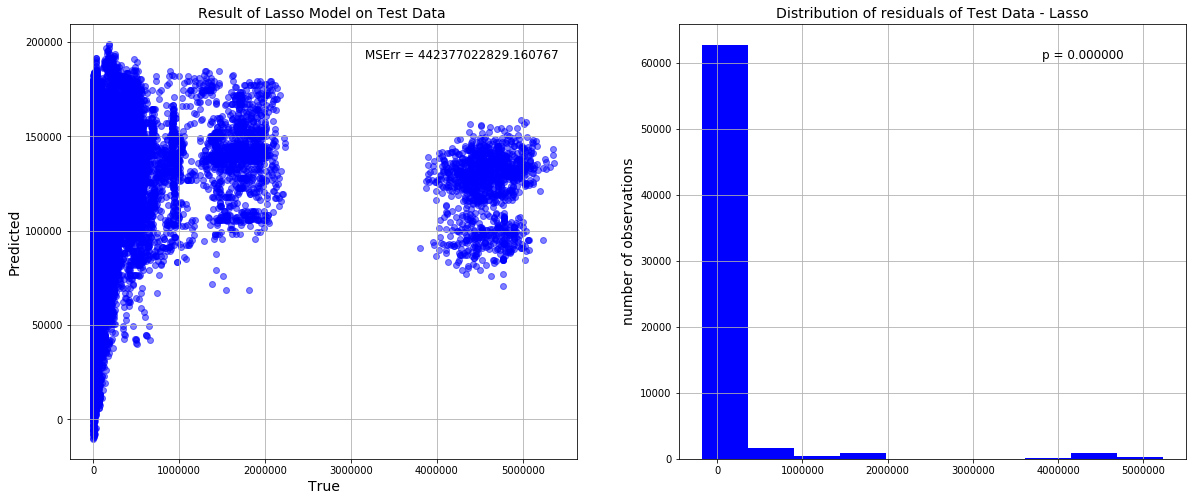

In [270]:
# plot regression results
fig6 = plt.figure(figsize=(20,8));
plt.subplot(1,2,1)
plt.scatter(y_test, best_lasso.predict(X_test),color='b', alpha=.5)
plt.plot([0,.6],[0,.6],'r-')
plt.title('Result of Lasso Model on Test Data ',fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('Predicted',fontsize=14)
plt.grid();
fig6.text(0.33, .82, 'MSErr = {:2f}'.format(MSE_Lt), fontsize=12);
 #plot residual dist
plt.subplot(1,2,2)
plt.hist(residuals,color='b');
plt.title('Distribution of residuals of Test Data - Lasso',fontsize=14);
plt.ylabel('number of observations',fontsize=14);
fig6.text(0.80, .82, 'p = {:2f}'.format(pdr[1]), fontsize=12);
plt.grid()

### NEXT STEPS...

Determine a way to handle NAs

Scale time-series

Try ARIMA model 

Be careful of over-fitting 